In [25]:
from glob import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom
from pydicom import dcmread
import os.path as osp
import os
import torch
from einops import rearrange
import numpy as np
from rt_utils.image_helper import get_pixel_to_patient_transformation_matrix, apply_transformation_to_3d_points
from PIL import Image, ImageDraw

from vlkit.medical import read_dicom_data
import vlkit.plt as vlplt

## Utility Functions

In [44]:
def get_transformation_matrix(input):
    print(input)
    dicoms = sorted([osp.join(input, i) for i in os.listdir(input) if i.endswith('dcm') or i.endswith('dicom')])
    dicoms = [pydicom.dcmread(d) for d in dicoms]
    transformation_matrix = get_pixel_to_patient_transformation_matrix(dicoms)
    return transformation_matrix

def transform_3D(dcm_data, index, mat):
    data = dcm_data.pixel_array
    h,w = data.shape
    x = np.arange(w)
    y = np.arange(h)
    x, y = np.meshgrid(x, y)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    points = np.concatenate((x, y), axis=1)
    p = np.concatenate((points, np.full((len(points), 1), index)), axis=1)
    patient_coords = apply_transformation_to_3d_points(p, mat)
    return (patient_coords, points, data)

def find_corners(coordinates):
    min_x = min(coordinates, key=lambda coord: coord[0])[0]
    max_x = max(coordinates, key=lambda coord: coord[0])[0]
    min_y = min(coordinates, key=lambda coord: coord[1])[1]
    max_y = max(coordinates, key=lambda coord: coord[1])[1]
    
    # Find the corners based on the calculated min and max values
    corner1 = (min_x, min_y, coordinates[0][2])
    corner2 = (max_x, max_y, coordinates[0][2])

    return corner1, corner2

def normalize_coordinates(top_left_big, bottom_right_big, top_left_small, bottom_right_small):
    big_width = bottom_right_big[0] - top_left_big[0]
    big_height = bottom_right_big[1] - top_left_big[1]

    scale_x = 2 / big_width
    scale_y = 2 / big_height

    normalized_top_left_big = (-1, -1)
    normalized_bottom_right_big = (1, 1)

    normalized_top_left_small = (
        ((top_left_small[0] - top_left_big[0]) * scale_x) - 1,
        ((top_left_small[1] - top_left_big[1]) * scale_y) - 1
    )
    normalized_bottom_right_small = (
        ((bottom_right_small[0] - top_left_big[0]) * scale_x) - 1,
        ((bottom_right_small[1] - top_left_big[1]) * scale_y) - 1
    )

    return normalized_top_left_big, normalized_bottom_right_big, normalized_top_left_small, normalized_bottom_right_small


# MRI
def interpolate_t2_to_ktrans_size(t2_tuple, ktrans_tuple):
    
    t2_c1, t2_c2 = find_corners(t2_tuple[0])
    kt_c1, kt_c2 = find_corners(ktrans_tuple[0])
    

    kt_c1, kt_c2, t2_c1, t2_c2 = normalize_coordinates(kt_c1, kt_c2, t2_c1, t2_c2)

    kt_data = torch.tensor(ktrans_tuple[2].tolist()).float()
    kt_data = rearrange(kt_data, "h w -> 1 1 h w")
    
    h = t2_tuple[1][-1][0] + 1
    w = t2_tuple[1][-1][1] + 1

    increment_h = (t2_c2[0] - t2_c1[0]) / (h - 1) if h > 1 else 0
    increment_w = (t2_c2[1] - t2_c1[1]) / (w - 1) if w > 1 else 0

    result_list_h = [t2_c1[0] + i * increment_h for i in range(h)]
    result_list_w = [t2_c1[1] + i * increment_w for i in range(w)]

    y_tensor = torch.tensor(result_list_h)
    x_tensor = torch.tensor(result_list_w)
    y, x = torch.meshgrid(y_tensor, x_tensor)

    xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim = 2).float()
    xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

    new_data = torch.nn.functional.grid_sample(kt_data, xy, align_corners=True)
    new_data = rearrange(new_data, "1 1 h w -> h w")
    return new_data

def print_2D(patient_coords):
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(111)
    
    #for (patient_coord, points, data) in patient_coords_list:
    patient_coord = patient_coords[0]
    points = patient_coords[1]
    data = patient_coords [2]

    data = ((data/data.max())).flatten()
    indice = np.random.choice(len(points), 100000)
    colors = [[c, c, c] for c in data[indice]]
    ax.scatter(patient_coord[indice,0], patient_coord[indice,1], color = colors)
    #ax.view_init(elev=30, azim=45)

def print_3D(patient_coords_list):
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(projection='3d')
    for (patient_coord, points, data) in patient_coords_list:
        data = ((data/data.max())).flatten()
        indice = np.random.choice(len(points), 100000)
        colors = [[c, c, c] for c in data[indice]]
        ax.scatter(patient_coord[indice,0], patient_coord[indice,1], patient_coord[indice,2], color = colors)
    ax.view_init(elev=30, azim=45)

def print_in_folder(patient_coords_list):
    i = 0
    for ((t2_patient_coord, t2_points, t2_data), (ktrans_patient_coord, ktrans_points, ktrans_data)) in patient_coords_list:
        point_size = 2
        t2_data = ((t2_data/t2_data.max())).flatten()
        ktrans_data = ((ktrans_data/ktrans_data.max())).flatten()
        
        t2_image = Image.new("RGB", (320,320), "black")
        ktrans_image = Image.new("RGB", (320,320), "black")

        t2_output_folder = "t2_folder"
        ktrans_output_folder = "ktrans_folder"

        
        def scale_list_to_255(values):
            scaled_values = [(int(value * 255)) for value in values]
            return scaled_values
        
        t2_data = scale_list_to_255(t2_data)
        ktrans_data = scale_list_to_255(ktrans_data)

        t2_draw = ImageDraw.Draw(t2_image)
        ktrans_draw = ImageDraw.Draw(ktrans_image)

        t2_colors = [(c, c, c) for c in t2_data]
        ktrans_colors = [(c, c, c) for c in ktrans_data]

        for coord, color in zip(t2_points, t2_colors):
            x, y = int(coord[0]), int(coord[1])  # Only take the x and y coordinates
            t2_draw.ellipse([(x - point_size, y - point_size), (x + point_size, y + point_size)], fill=color)

        for coord, color in zip(ktrans_points, ktrans_colors):
            x, y = int(coord[0]), int(coord[1])  # Only take the x and y coordinates
            
            ktrans_draw.ellipse([(x - point_size, y - point_size), (x + point_size, y + point_size)], fill=color)

        # Create output folder if it doesn't exist
        if not os.path.exists(t2_output_folder):
            os.makedirs(t2_output_folder)
        if not os.path.exists(ktrans_output_folder):
            os.makedirs(ktrans_output_folder)
        # Save the image to the output folder
        t2_image_path = os.path.join(t2_output_folder, "t2w_" + str(i) + ".png")
        ktrans_image_path = os.path.join(ktrans_output_folder, "ktrans_" + str(i) + ".png")
        i += 1
        t2_image.save(t2_image_path)
        ktrans_image.save(ktrans_image_path)


############################################################################################################################

def two_files_align(t2_folder, ktrans_folder):
    t2data = read_dicom_data(t2_folder, cat=True)
    ktrans_data = read_dicom_data(ktrans_folder, cat=True)

    t2_mat = get_transformation_matrix(t2_folder)
    new_t2_mat = np.array(t2_mat)

    t2_patient_coords_list = []
    for i,filename in enumerate(os.listdir(t2_folder)):
        full_path = os.path.join(t2_folder, filename)

        t2_img1_dcm = pydicom.dcmread(full_path)

        patient_coords = transform_3D(t2_img1_dcm, i, new_t2_mat)
        t2_patient_coords_list.append(patient_coords)


    ktrans_mat = get_transformation_matrix(ktrans_folder)
    new_ktrans_mat = np.array(ktrans_mat)
    ktrans_patient_coords_list = []
    for i,filename in enumerate(os.listdir(ktrans_folder)):
        full_path = os.path.join(ktrans_folder, filename)

        ktrans_img1_dcm = pydicom.dcmread(full_path)

        patient_coords = transform_3D(ktrans_img1_dcm, i, new_ktrans_mat)
        ktrans_patient_coords_list.append(patient_coords)

    t2_and_ktrans_patient_coords_list = []
    aligned_ktrans = []
    for i in range(len(t2_patient_coords_list)):
        new_data = interpolate_t2_to_ktrans_size(t2_patient_coords_list[i], ktrans_patient_coords_list[i])
        aligned_ktrans.append(new_data[None, :, :])

        ktrans_patient_coords_list[i] = (t2_patient_coords_list[i][0], t2_patient_coords_list[i][1], new_data)

        t2_and_ktrans_patient_coords_list.append((t2_patient_coords_list[i], ktrans_patient_coords_list[i]))

    return torch.cat(aligned_ktrans, dim=0), t2data

## Interpolation: Toy Example

In [45]:
import torch
from einops import rearrange

data = torch.tensor([[1,2], [3,4]]).float()
print(data)
data = rearrange(data, "h w -> 1 1 h w")
print(data.shape)
print(data)

y, x = torch.meshgrid(torch.tensor([-1, -0.5, 0, 0.5, 1]), torch.tensor([-1, -0.5, 0, 0.5, 1]))


print("y = ", y)
print('-----------')
print("x = ", x)


# 3x3x2
xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim=2).float()


# 1x3x3x2
xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

# print(xy)



tensor([[1., 2.],
        [3., 4.]])
torch.Size([1, 1, 2, 2])
tensor([[[[1., 2.],
          [3., 4.]]]])
y =  tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.5000,  0.5000,  0.5000,  0.5000,  0.5000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000]])
-----------
x =  tensor([[-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000],
        [-1.0000, -0.5000,  0.0000,  0.5000,  1.0000]])


In [46]:
torch.nn.functional.grid_sample(data, xy, align_corners=True)

tensor([[[[1.0000, 1.2500, 1.5000, 1.7500, 2.0000],
          [1.5000, 1.7500, 2.0000, 2.2500, 2.5000],
          [2.0000, 2.2500, 2.5000, 2.7500, 3.0000],
          [2.5000, 2.7500, 3.0000, 3.2500, 3.5000],
          [3.0000, 3.2500, 3.5000, 3.7500, 4.0000]]]])

In [47]:
# 3 * 3

data = torch.tensor([[1,2,3], [4,5,6], [7,8,9]]).float()
data = rearrange(data, "h w -> 1 1 h w")
print(data.shape)

# makes a 5*5 matrix with positions from -1 to 1, refer to middle as (0,0)
y, x = torch.meshgrid(torch.tensor([-1, -0.5, 0, 0.5, 1]), torch.tensor([-1, -0.5, 0, 0.5, 1]))

xy = torch.cat((x.unsqueeze(dim=-1), y.unsqueeze(dim=-1)), dim = 2).float()
xy = rearrange(xy, 'h w d -> 1 h w d', d=2)

print(xy)

torch.Size([1, 1, 3, 3])
tensor([[[[-1.0000, -1.0000],
          [-0.5000, -1.0000],
          [ 0.0000, -1.0000],
          [ 0.5000, -1.0000],
          [ 1.0000, -1.0000]],

         [[-1.0000, -0.5000],
          [-0.5000, -0.5000],
          [ 0.0000, -0.5000],
          [ 0.5000, -0.5000],
          [ 1.0000, -0.5000]],

         [[-1.0000,  0.0000],
          [-0.5000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.5000,  0.0000],
          [ 1.0000,  0.0000]],

         [[-1.0000,  0.5000],
          [-0.5000,  0.5000],
          [ 0.0000,  0.5000],
          [ 0.5000,  0.5000],
          [ 1.0000,  0.5000]],

         [[-1.0000,  1.0000],
          [-0.5000,  1.0000],
          [ 0.0000,  1.0000],
          [ 0.5000,  1.0000],
          [ 1.0000,  1.0000]]]])


In [48]:
new_data = torch.nn.functional.grid_sample(data, xy, align_corners=True)
new_data = rearrange(new_data, "1 1 h w -> h w")
print(new_data)

tensor([[1.0000, 1.5000, 2.0000, 2.5000, 3.0000],
        [2.5000, 3.0000, 3.5000, 4.0000, 4.5000],
        [4.0000, 4.5000, 5.0000, 5.5000, 6.0000],
        [5.5000, 6.0000, 6.5000, 7.0000, 7.5000],
        [7.0000, 7.5000, 8.0000, 8.5000, 9.0000]])


## Overlay

data/t2/
data/ktrans/
(20, 320, 320) torch.Size([20, 320, 320])


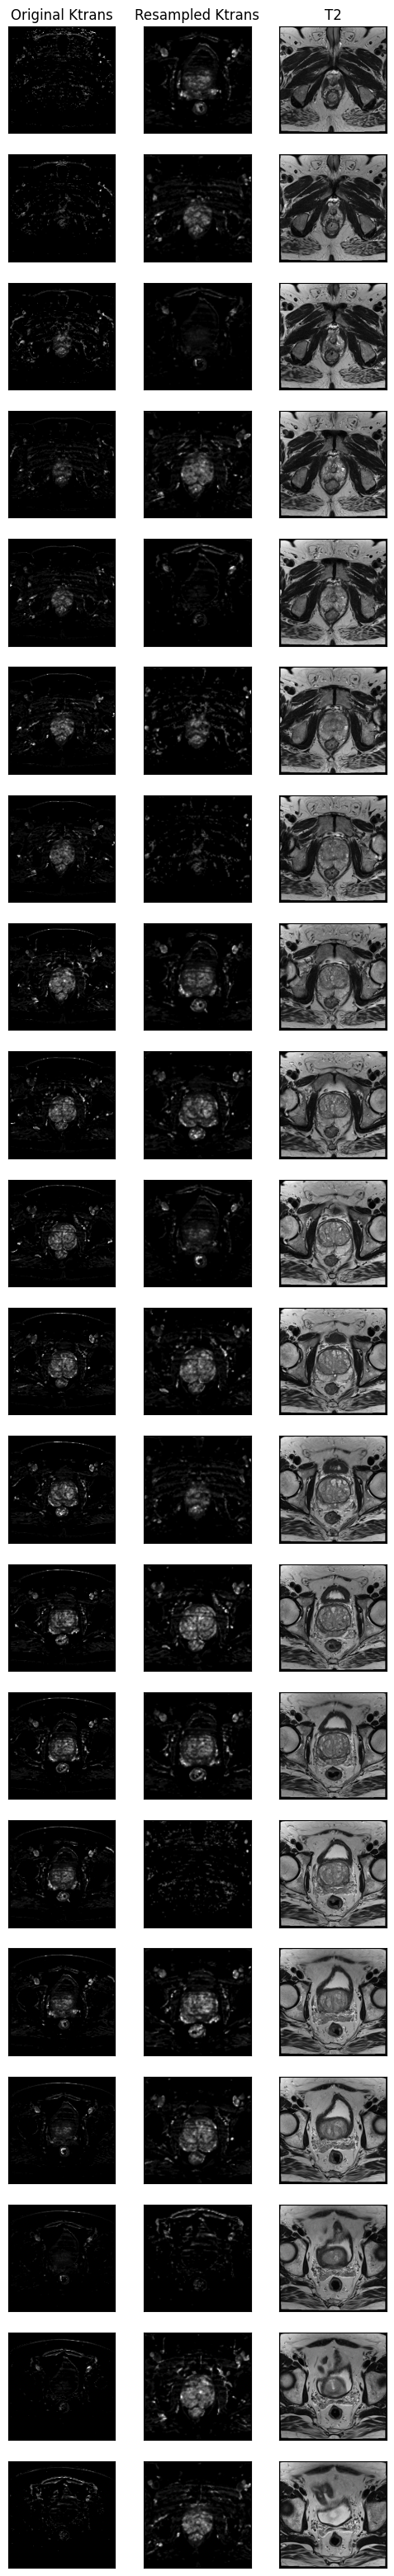

In [52]:
ktrans_folder = 'data/ktrans/'
t2_folder = 'data/t2/'

# t2_and_ktrans_patient_coords_list is a list of tuples (t2,ktrans)
orig_ktrans = read_dicom_data(ktrans_folder, cat=True)
ktrans, t2 = two_files_align(t2_folder, ktrans_folder)

fig, axes = plt.subplots(t2.shape[0], 3, figsize=(6, t2.shape[0]*2))

axes[0, 0].set_title("Original Ktrans")
axes[0, 1].set_title("Resampled Ktrans")
axes[0, 2].set_title("T2")

vlplt.clear_ticks(axes)

print(t2.shape, ktrans.shape)
for i in range(t2.shape[0]):
    axes[i, 0].imshow(orig_ktrans[i, :, :], cmap='Greys_r')
    axes[i, 1].imshow(ktrans[i, :, :], cmap='Greys_r')
    axes[i, 2].imshow(t2[i, :, :], cmap='Greys_r')


In [42]:
t2.shape

(20, 320, 320)

In [43]:
ktrans.shape

torch.Size([320, 320, 20])